# Prepare the Data
## Set Constants
Set constants

In [1]:
import os

ROOT = r"./"
DATA_IN = os.path.join(ROOT, "data", "income-predictor")
SOURCE_DATASET = os.path.join(DATA_IN ,"adult.data")
SOURCE_ATTRIBUTES = os.path.join(DATA_IN, "attributes.csv")
SOURCE_TEST_DATA = os.path.join(DATA_IN, "adult.test")
COMBINED_DATA_OUT = f'{SOURCE_DATASET}.full'

LABEL_COL='>50K'


print(SOURCE_DATASET)
print(SOURCE_ATTRIBUTES)
print(SOURCE_TEST_DATA)

./data/income-predictor/adult.data
./data/income-predictor/attributes.csv
./data/income-predictor/adult.test


## Instantiate Spark Session

In [2]:
from pyspark.sql import SparkSession, DataFrame

spark=SparkSession \
    .builder \
    .appName("Income Predictor") \
    .getOrCreate()

## Create Schema
An attributes file was created from the [data's decription](http://archive.ics.uci.edu/ml/datasets/Census+Income)

In [3]:
from pyspark.sql.types import StructType, StructField, IntegerType, DecimalType, StringType, BooleanType

attrs = spark.read.csv(SOURCE_ATTRIBUTES, header=True)
attrs.show()

def get_field(t: str):
    if t == "continuous":
        return DecimalType()
    elif t == "string":
        return StringType()
    elif t == "boolean":
        return BooleanType()
    else:
        raise Exception("Not expected: %s" % t)

def to_struct(row) -> StructField:
    return StructField(row['description'], get_field(row['type']), nullable=False)

struct_fields = attrs.rdd.map(to_struct).collect()

schema=StructType(struct_fields)

+-----+----------+--------------+--------------------+
| name|      type|   description|              values|
+-----+----------+--------------+--------------------+
|  f_1|continuous|           age|                null|
|  f_2|    string|     workclass|Private, Self-emp...|
|  f_3|continuous|        fnlwgt|                null|
|  f_4|    string|     education|Bachelors, Some-c...|
|  f_5|continuous| education-num|                null|
|  f_6|    string|marital-status|Married-civ-spous...|
|  f_7|    string|    occupation|Tech-support, Cra...|
|  f_8|    string|  relationship|Wife, Own-child, ...|
|  f_9|    string|          race|White, Asian-Pac-...|
| f_10|    string|           sex|        Female, Male|
| f_11|continuous|  capital-gain|                null|
| f_12|continuous|  capital-loss|                null|
| f_13|continuous|hours-per-week|                null|
| f_14|    string|native-country|United-States, Ca...|
|label|    string|         label|              "<=50k|
+-----+---

## Load the Training Data
We'll also create a function `load_data(file: str)` which can be used to load the test data later.

In [4]:
def load_data(file: str):
    return spark.read.load(file, format="csv", sep=",", header=False, ignoreLeadingWhiteSpace=True, ignoreTrailingWhiteSpace=True, schema=schema)

df = load_data(SOURCE_DATASET)
df.show(5)
df.printSchema()
df.count()

+---+----------------+------+---------+-------------+------------------+-----------------+-------------+-----+------+------------+------------+--------------+--------------+-----+
|age|       workclass|fnlwgt|education|education-num|    marital-status|       occupation| relationship| race|   sex|capital-gain|capital-loss|hours-per-week|native-country|label|
+---+----------------+------+---------+-------------+------------------+-----------------+-------------+-----+------+------------+------------+--------------+--------------+-----+
| 39|       State-gov| 77516|Bachelors|           13|     Never-married|     Adm-clerical|Not-in-family|White|  Male|        2174|           0|            40| United-States|<=50K|
| 50|Self-emp-not-inc| 83311|Bachelors|           13|Married-civ-spouse|  Exec-managerial|      Husband|White|  Male|           0|           0|            13| United-States|<=50K|
| 38|         Private|215646|  HS-grad|            9|          Divorced|Handlers-cleaners|Not-in-fam

32561

# Clean Training Data
As it is, the training data is not ready for planned analysis:

## Convert Label Column
Our categorisation model will aim to predict whether an individual earns more than $50k per year. Since there are only two categories, we can express this as a binary integer or boolean type.

The function `convert_label_col(df: DataFrame)` will be created and used again later.

In [5]:
import pyspark.sql.functions as f

def convert_label_col(df: DataFrame):
    df=df.withColumnRenamed('label', LABEL_COL)
    df=df.withColumn(LABEL_COL, f.when(f.col(LABEL_COL) == '>50K', 'True').otherwise('False'))
    return df.withColumn(LABEL_COL, df[LABEL_COL].cast(BooleanType()))

df = convert_label_col(df)

df.select(LABEL_COL).show(10)



+-----+
| >50K|
+-----+
|false|
|false|
|false|
|false|
|false|
|false|
|false|
| true|
| true|
| true|
+-----+
only showing top 10 rows



## Handle Missing Data
Missing values have been replaced with a '?' character. These values may make our model less accurate.



In [6]:
def count_rows_with_missing_data(df: DataFrame):
    return df.select([f.sum(f.when(f.col(c) == '?', 1).otherwise(0)).alias(c) for c in df.columns])

count_rows_with_missing_data(df).show()

+---+---------+------+---------+-------------+--------------+----------+------------+----+---+------------+------------+--------------+--------------+----+
|age|workclass|fnlwgt|education|education-num|marital-status|occupation|relationship|race|sex|capital-gain|capital-loss|hours-per-week|native-country|>50K|
+---+---------+------+---------+-------------+--------------+----------+------------+----+---+------------+------------+--------------+--------------+----+
|  0|     1836|     0|        0|            0|             0|      1843|           0|   0|  0|           0|           0|             0|           583|   0|
+---+---------+------+---------+-------------+--------------+----------+------------+----+---+------------+------------+--------------+--------------+----+



There are a few ways to deal with them:
* Remove entries with missing values (so long as this is not a significant number)
* Impute missing values (if continuous)
```python
NUMERIC_COLUMNS=['capital-gain','capital-loss']
imputer = Imputer(
    inputCols=NUMERIC_COLUMNS,
    outputCols=["{}_imputed".format(c) for c in NUMERIC_COLUMNS]
)
df=imputer.fit(df).transform(df)
```
* Assign them a string value (in this case '?') and include them in the model

Note that none of our numeric columns contain missing data:

In [7]:
#create a list of the columns that are string typed
categoricalColumns = [item[0] for item in df.dtypes if item[1].startswith('string')]
numericColumns = [item[0] for item in df.dtypes if item[1].startswith('decimal')]

print(f'Numeric: {numericColumns}')
print(f'Categorical: {categoricalColumns}')

count_rows_with_missing_data(df).select(numericColumns).show()

Numeric: ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
Categorical: ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
+---+------+-------------+------------+------------+--------------+
|age|fnlwgt|education-num|capital-gain|capital-loss|hours-per-week|
+---+------+-------------+------------+------------+--------------+
|  0|     0|            0|           0|           0|             0|
+---+------+-------------+------------+------------+--------------+



Therefore we do not need to impute these values. 

Filtering out all the missing values, we can see the impact this has on the dataset:

In [8]:
def remove_rows_with_missing_categorical_data(df: DataFrame):
    categoricalColumns = [item[0] for item in df.dtypes if item[1].startswith('string')]
    for col in categoricalColumns:
        df=df.filter(df[col]!='?')
    return df

total_rows=df.count()
rows_with_missing_data=total_rows-remove_rows_with_missing_categorical_data(df).count()
percentage=rows_with_missing_data*100/total_rows

print(percentage)

7.36770983692147


Removing these entries should be benificial for our model but it is probably worth keeping them for other forms of analysis.

We shall export the data for further analysis and clean the empty values when training our model:

In [9]:


test_data=load_data(SOURCE_TEST_DATA)
# test_data=remove_superfluous_cols(test_data)
test_data=convert_label_col(test_data)

# Combine prepared test data and training data for use with Tableau later
df_combined = df.union(test_data)

df_combined.repartition(1).write.csv(COMBINED_DATA_OUT, header=True, sep=',', mode='overwrite')



# Exploring Data Characteristics
When representing the population, we must multiply any counts by fnlwgt to get the true proportion.

In [10]:
print('Sex:')
df_combined.groupby('sex').count().show()

print('Education:')
df_combined.groupby('education').count().show()

print('Education_num:')
df_combined.groupby('education-num').count().sort('education-num', ascending=False).show()


Sex:
+------+-----+
|   sex|count|
+------+-----+
|Female|16192|
|  Male|32650|
+------+-----+

Education:
+------------+-----+
|   education|count|
+------------+-----+
|     Masters| 2657|
|        10th| 1389|
|     5th-6th|  509|
|  Assoc-acdm| 1601|
|   Assoc-voc| 2061|
|     7th-8th|  955|
|         9th|  756|
|     HS-grad|15784|
|   Bachelors| 8025|
|        11th| 1812|
|     1st-4th|  247|
|   Preschool|   83|
|        12th|  657|
|   Doctorate|  594|
|Some-college|10878|
| Prof-school|  834|
+------------+-----+

Education_num:
+-------------+-----+
|education-num|count|
+-------------+-----+
|           16|  594|
|           15|  834|
|           14| 2657|
|           13| 8025|
|           12| 1601|
|           11| 2061|
|           10|10878|
|            9|15784|
|            8|  657|
|            7| 1812|
|            6| 1389|
|            5|  756|
|            4|  955|
|            3|  509|
|            2|  247|
|            1|   83|
+-------------+-----+



In [11]:

distinct_countries_count=df.select(['native-country']).distinct().count()
print(f'Number of distinct countries: {distinct_countries_count}')
df_combined.groupby('native-country').count().show(distinct_countries_count)



Number of distinct countries: 42
+--------------------+-----+
|      native-country|count|
+--------------------+-----+
|         Philippines|  295|
|             Germany|  206|
|            Cambodia|   28|
|              France|   38|
|              Greece|   49|
|              Taiwan|   65|
|             Ecuador|   45|
|           Nicaragua|   49|
|                Hong|   30|
|                Peru|   46|
|               India|  151|
|               China|  122|
|               Italy|  105|
|  Holand-Netherlands|    1|
|                Cuba|  138|
|               South|  115|
|                Iran|   59|
|             Ireland|   37|
|            Thailand|   30|
|                Laos|   23|
|         El-Salvador|  155|
|              Mexico|  951|
|           Guatemala|   88|
|            Honduras|   20|
|          Yugoslavia|   23|
|         Puerto-Rico|  184|
|             Jamaica|  106|
|              Canada|  182|
|       United-States|43832|
|  Dominican-Republic|  103|
|Outlying-

# Preparing the Model
We are going to train a Logistic Regression modal to classify the data. In order to do that, each row must be converted into numeric vector data.

## Irrelevant Data
fnlwgt (Final Weight) does not relate to the individual entry; rather it describes the proportion of the population that this entry represents.

It has no use in our analysis and can be removed.

We can also remove 'education' as this is already indexed in the column 'education-num'.

The function `remove_superfluous_cols(df)` will be reused when preparing our test data.

In [12]:
def remove_superfluous_cols(df: DataFrame):
    df=df.drop('fnlwgt')
    return df.drop('education')

df_clean = remove_superfluous_cols(df)

df_clean.show(5)

+---+----------------+-------------+------------------+-----------------+-------------+-----+------+------------+------------+--------------+--------------+-----+
|age|       workclass|education-num|    marital-status|       occupation| relationship| race|   sex|capital-gain|capital-loss|hours-per-week|native-country| >50K|
+---+----------------+-------------+------------------+-----------------+-------------+-----+------+------------+------------+--------------+--------------+-----+
| 39|       State-gov|           13|     Never-married|     Adm-clerical|Not-in-family|White|  Male|        2174|           0|            40| United-States|false|
| 50|Self-emp-not-inc|           13|Married-civ-spouse|  Exec-managerial|      Husband|White|  Male|           0|           0|            13| United-States|false|
| 38|         Private|            9|          Divorced|Handlers-cleaners|Not-in-family|White|  Male|           0|           0|            40| United-States|false|
| 53|         Private|

## Remove unknown values
As previously discussed, we will remove the rows with unknown text values which cannot be imputed.

In [13]:
df_clean=remove_rows_with_missing_categorical_data(df_clean)

count_rows_with_missing_data(df_clean).show()

+---+---------+-------------+--------------+----------+------------+----+---+------------+------------+--------------+--------------+----+
|age|workclass|education-num|marital-status|occupation|relationship|race|sex|capital-gain|capital-loss|hours-per-week|native-country|>50K|
+---+---------+-------------+--------------+----------+------------+----+---+------------+------------+--------------+--------------+----+
|  0|        0|            0|             0|         0|           0|   0|  0|           0|           0|             0|             0|   0|
+---+---------+-------------+--------------+----------+------------+----+---+------------+------------+--------------+--------------+----+



## Create Feature Vector Data
Now we can convert all string values into numeric index values using a string indexer:

In [14]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer

indexers = [StringIndexer(inputCol=column, outputCol=column+"_indexed").fit(df) for column in categoricalColumns ]
pipeline = Pipeline(stages=indexers)


def index_strings(df: DataFrame):
    dfi=pipeline.fit(df).transform(df)
    return dfi.drop(*categoricalColumns).withColumn(LABEL_COL, df[LABEL_COL].cast(IntegerType()))

df_indexed=index_strings(df_clean)
df_indexed.show(5)

+---+-------------+------------+------------+--------------+----+-----------------+----------------------+------------------+--------------------+------------+-----------+----------------------+
|age|education-num|capital-gain|capital-loss|hours-per-week|>50K|workclass_indexed|marital-status_indexed|occupation_indexed|relationship_indexed|race_indexed|sex_indexed|native-country_indexed|
+---+-------------+------------+------------+--------------+----+-----------------+----------------------+------------------+--------------------+------------+-----------+----------------------+
| 39|           13|        2174|           0|            40|   0|              4.0|                   1.0|               3.0|                 1.0|         0.0|        0.0|                   0.0|
| 50|           13|           0|           0|            13|   0|              1.0|                   0.0|               2.0|                 0.0|         0.0|        0.0|                   0.0|
| 38|            9|      

## Check for Redundant Features

Now that we indexed all our string values, we can create a correlation matrix between each feature.

If two features have a high correlation, we can view one or more of these as redundant and remove it from our machine learning model.

['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass_indexed', 'marital-status_indexed', 'occupation_indexed', 'relationship_indexed', 'race_indexed', 'sex_indexed', 'native-country_indexed']


/usr/local/spark/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


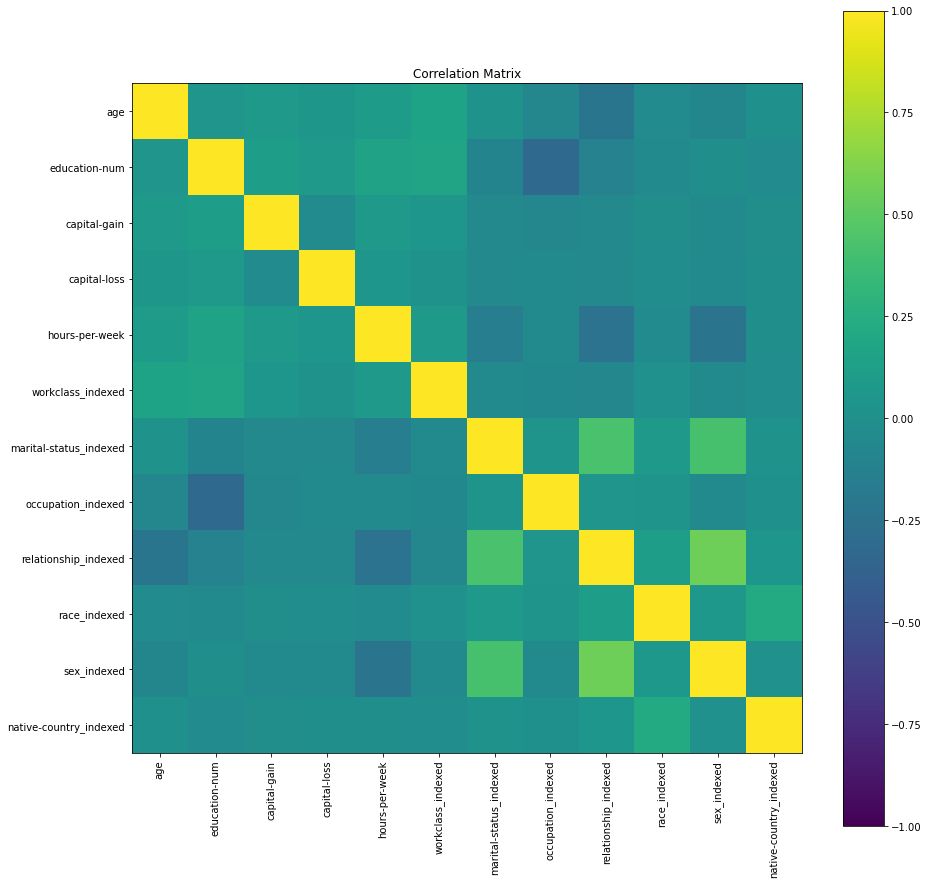

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation


corr_graph=df_indexed.drop(LABEL_COL)

columns = corr_graph.columns
print(columns)
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=corr_graph.columns, 
                            outputCol=vector_col)
corr_graph_vector = assembler.transform(corr_graph).select(vector_col)
matrix = Correlation.corr(corr_graph_vector, vector_col)

matrix = Correlation.corr(corr_graph_vector, vector_col).collect()[0][0]
corrmatrix = matrix.toArray().tolist()
# print(corrmatrix)

df = spark.createDataFrame(corrmatrix,columns)

def plot_corr_matrix(correlations,attr,fig_no):
    fig=plt.figure(figsize=(15,15))
    ax=fig.add_subplot(111)
    ax.set_title("Correlation Matrix")
    ax.set_xticks(np.arange(len(attr)))
    ax.set_yticks(np.arange(len(attr)))
    ax.set_xticklabels(attr, rotation=90, fontsize=10)
    ax.set_yticklabels(attr, fontsize=10)
    cax=ax.imshow(correlations,vmax=1,vmin=-1)
    fig.colorbar(cax)
    plt.show()

plot_corr_matrix(corrmatrix, columns, 234)

## Create Feature Vectors

In [16]:
from pyspark.ml.feature import VectorAssembler, Normalizer
VECTOR_COL='features'

features=list(df_indexed.drop(LABEL_COL).toPandas().columns)

assembler=VectorAssembler(inputCols=features, outputCol=VECTOR_COL)

def create_feature_vector(df):
    df_vector = assembler.transform(df)
    return df_vector.select(*[VECTOR_COL, LABEL_COL])

df_vector = create_feature_vector(df_indexed)
df_vector.show(5)

+--------------------+----+
|            features|>50K|
+--------------------+----+
|[39.0,13.0,2174.0...|   0|
|(12,[0,1,4,5,7],[...|   0|
|(12,[0,1,4,6,7,8]...|   0|
|(12,[0,1,4,7,9],[...|   0|
|[28.0,13.0,0.0,0....|   0|
+--------------------+----+
only showing top 5 rows



## Normalise Vectors

We to normalize the feature vectors using $L^1$ norm 

In [17]:
normalizer = Normalizer().setInputCol(VECTOR_COL).setOutputCol(f'{VECTOR_COL}_n').setP(1.0)


def normalize_vector(df_vector):
    df_vector = normalizer.transform(df_vector)
    return df_vector.drop(VECTOR_COL).withColumnRenamed(f'{VECTOR_COL}_n',VECTOR_COL)

df_vector = normalize_vector(df_vector)
df_vector.show(5)


+----+--------------------+
|>50K|            features|
+----+--------------------+
|   0|[0.01714285714285...|
|   0|(12,[0,1,4,5,7],[...|
|   0|(12,[0,1,4,6,7,8]...|
|   0|(12,[0,1,4,7,9],[...|
|   0|[0.29166666666666...|
+----+--------------------+
only showing top 5 rows



# Classification

Logical Regression adapted from example in Spark documentation: https://spark.apache.org/docs/3.0.1/ml-pipeline.html

## Configure Logistical Regression Instance


In [18]:
from pyspark.ml.classification import LogisticRegression

training_data=df_vector

# Create a LogisticRegression instance. This instance is an Estimator.
lr = LogisticRegression(maxIter=10, regParam=0.01, featuresCol=VECTOR_COL, labelCol=LABEL_COL)
# Print out the parameters, documentation, and any default values.
print(f"LogisticRegression parameters:")
lr.explainParams()


LogisticRegression parameters:


"aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)\nelasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)\nfamily: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)\nfeaturesCol: features column name. (default: features, current: features)\nfitIntercept: whether to fit an intercept term. (default: True)\nlabelCol: label column name. (default: label, current: >50K)\nlowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)\nlowerBoundsOnIntercepts: The lower bounds on intercepts if fitting under bound constrained optimizati

## Train the Model
Train the model using the training data we prepared earlier

In [19]:
training_data=df_vector
# Learn a LogisticRegression models. This uses the parameters stored in lr.
model1 = lr.fit(training_data)
print("Model 1 was fit using parameters: ")
model1.extractParamMap()

Model 1 was fit using parameters: 


{Param(parent='LogisticRegression_0b80f0b93f0f', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2).'): 2,
 Param(parent='LogisticRegression_0b80f0b93f0f', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0,
 Param(parent='LogisticRegression_0b80f0b93f0f', name='family', doc='The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial'): 'auto',
 Param(parent='LogisticRegression_0b80f0b93f0f', name='featuresCol', doc='features column name.'): 'features',
 Param(parent='LogisticRegression_0b80f0b93f0f', name='fitIntercept', doc='whether to fit an intercept term.'): True,
 Param(parent='LogisticRegression_0b80f0b93f0f', name='labelCol', doc='label column name.'): '>50K',
 Param(parent='LogisticRegression_0b80f0b93f0f', name='maxBlockSizeInMB', doc='maximum memory in MB for st

## Prepare the Test Data
In a seperate file, additional values, with their classifications, is stored.

We will load this data and prepare it as we did our training data:

In [20]:
test_data=load_data(SOURCE_TEST_DATA)
test_data=remove_superfluous_cols(test_data)
test_data=convert_label_col(test_data)
test_data=index_strings(test_data)
test_data=create_feature_vector(test_data)
test_data=normalize_vector(test_data)

test_data.show(5)

+----+--------------------+
|>50K|            features|
+----+--------------------+
|   0|[0.30487804878048...|
|   0|(12,[0,1,4,7],[0....|
|   1|(12,[0,1,4,5,7],[...|
|   1|(12,[0,1,2,4,7,9]...|
|   0|[0.25,0.138888888...|
+----+--------------------+
only showing top 5 rows



## Make Predictions
Finally we can can put our model to the test.

In [21]:
model=model1
# Make predictions on test data using the Transformer.transform() method.
# LogisticRegression.transform will only use the 'features' column.
prediction = model.transform(test_data)

prediction.select(['>50K', 'prediction' ]).show()

+----+----------+
|>50K|prediction|
+----+----------+
|   0|       0.0|
|   0|       0.0|
|   1|       0.0|
|   1|       1.0|
|   0|       0.0|
|   0|       0.0|
|   0|       0.0|
|   1|       1.0|
|   0|       0.0|
|   0|       0.0|
|   1|       1.0|
|   0|       1.0|
|   0|       0.0|
|   0|       0.0|
|   1|       1.0|
|   1|       0.0|
|   0|       0.0|
|   0|       0.0|
|   0|       0.0|
|   1|       0.0|
+----+----------+
only showing top 20 rows



## Evaluate the Model

Finally, we can evaluate the success of our model with a classification evaluator:

In [22]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# obtain evaluator.
evaluator = MulticlassClassificationEvaluator(metricName='accuracy', labelCol=LABEL_COL)
# compute the classification error on test data.
accuracy = evaluator.evaluate(prediction)

if not evaluator.isLargerBetter():
    accuracy = 1 - accuracy
    
print("Test Accuracy = %g" % accuracy)



Test Accuracy = 0.797371
